In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from scipy.special import comb
import pandas as pd
import seaborn
import pprint
import deepdiff
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [77]:
from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.gbm import GBM
from rivapy.instruments.specifications import EuropeanVanillaSpecification
from rivapy.pricing.vanillaoption_pricing import VanillaOptionDeepHedgingPricer, DeepHedgeModel 


import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#%load_ext autoreload
#%autoreload 2
#%matplotlib inline

In [78]:
np.random.seed(42)
n = 365
T = 1.
timegrid = np.linspace(0.0,T,n) # simulate on daily timegrid over 1 yr horizon
model = GBM(drift = 0.1, volatility=0.3)
n_sims = 100
S0 = 100
paths = model.simulate(timegrid, start_value=S0,M = n_sims, n=n)


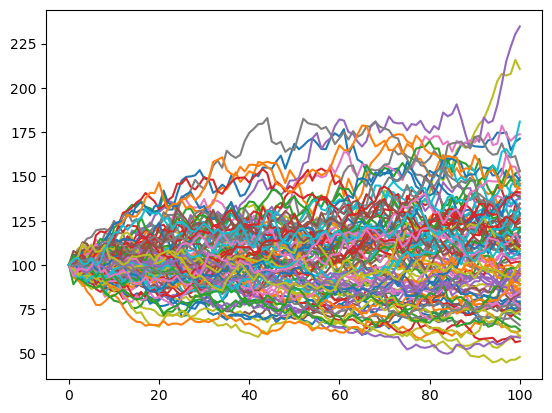

In [79]:
plt.plot(paths)

In [23]:
refdate = dt.datetime(2023,1,1)
issuer = 'DBK'
seclevel = 'COLLATERALIZED'
currency = 'EUR'
tpe = 'CALL' # Change to 'PUT' if you want to calculate the price of an european put option.
expiry = refdate + dt.timedelta(days=365)
strike = 60
spec = EuropeanVanillaSpecification('Test_call', tpe, expiry, strike, 
                                                       issuer = issuer, sec_lvl = seclevel, curr='EUR',udl_id='ADS',
                                                       share_ratio = 1)

In [24]:
repo = analysis.Repo('./experiments/')

In [25]:
repo.results.keys()

dict_keys([])

In [26]:
pricing_result =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.0,
                                      epochs=1, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, decay_rate=0.8, seed=42)

(<tf.Tensor 'IteratorGetNext:0' shape=(100, 365) dtype=float32>,)
(<tf.Tensor 'IteratorGetNext:0' shape=(100, 365) dtype=float32>,)
307/900 [=========>....................] - ETA: 3:27 - loss: 8.8931e-07

In [14]:
pnl = pricing_result.hedge_model.compute_pnl(pricing_result.paths, pricing_result.payoff)
inputs = pricing_result.hedge_model._create_inputs(pricing_result.paths)
loss = pricing_result.hedge_model.evaluate(inputs, pricing_result.payoff)
delta = pricing_result.hedge_model.compute_delta()

test = {'mean': pnl.mean(), 'var': pnl.var(), 
            'loss': loss,
            '1%':np.percentile(pnl,1), '99%': np.percentile(pnl,99),
            '5%':np.percentile(pnl,5), '95%': np.percentile(pnl,95)}

3125/3125 [==============================] - 71s 23ms/step - loss: 8.0422e-09


In [16]:
print(pnl)

[0.20404598 0.20421901 0.20418364 ... 0.20423794 0.20394962 0.20404618]


Text(0.5, 0, 'PnL')

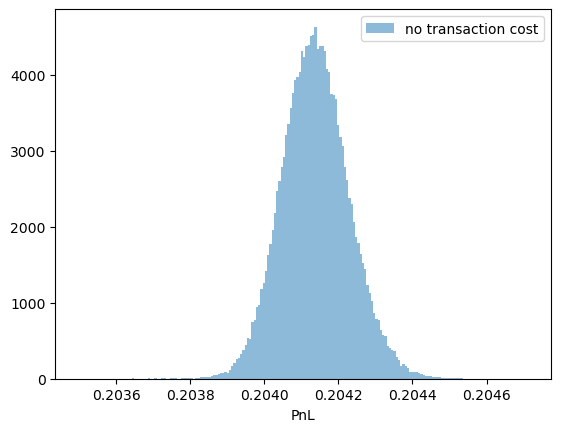

In [18]:
plt.hist(pnl, bins=200, label='no transaction cost', density=True, alpha=0.5)
plt.legend()
plt.xlabel('PnL')